In [2]:
import collections

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tskit
import tszip

### We examine the recombinant sequences reported by [Jackson et al. (2021)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8367733/)

In [3]:

ts = tszip.decompress("../data/sc2ts_viridian_v1.1.trees.tsz")


CPU times: user 598 ms, sys: 210 ms, total: 808 ms
Wall time: 650 ms


# Recombinants from Jackson et al. (2021)

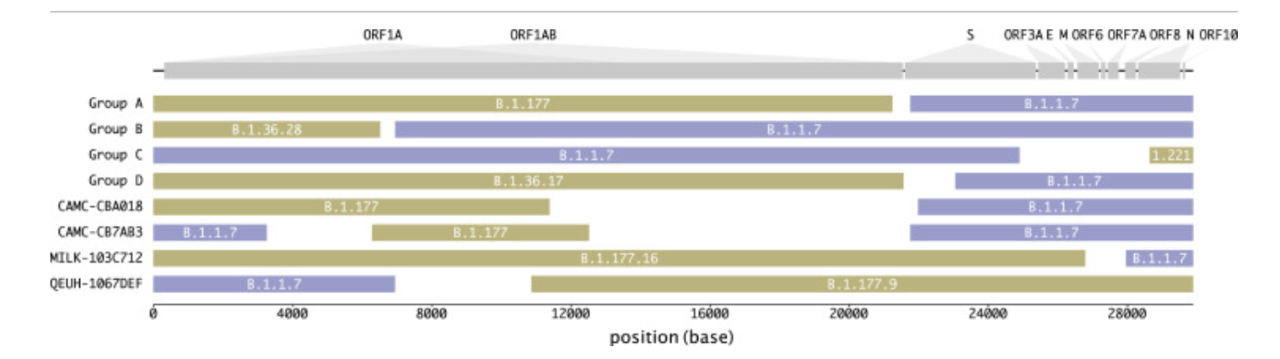


In [13]:
import io
f = io.StringIO("""
sample_id|strain_name|group|sampling_date
ERR5308556|ALDP-11CF93B|Group A|2021-01-30
ERR5323237|ALDP-125C4D7|Group A|2021-02-06
ERR5414941|ALDP-130BB95|Group A|2021-02-21
ERR5404883|LIVE-DFCFFE|Group A|2021-02-14
ERR5058070|QEUH-CCCB30|Group B|2020-12-23
ERR5058141|QEUH-CD0F1F|Group B|2020-12-24
ERR5272107|MILK-1166F52|Group C|2021-01-24
ERR5406307|MILK-11C95A6|Group C|2021-01-30
ERR5232711|QEUH-109B25C|Group C|2021-01-18
ERR5349458|MILK-126FE1F|Group D|2021-02-07
ERR5335088|RAND-12671E1|Group D|2021-02-02
ERR5340986|RAND-128FA33|Group D|2021-02-02
ERR5054123|CAMC-CBA018|singleton|2020-12-18
ERR5054082|CAMC-CB7AB3|singleton|2020-12-18
ERR5304348|MILK-103C712|singleton|2021-01-12
ERR5238288 |QEUH-1067DEF|singleton|2021-01-17
""")

df = pd.read_csv(f, sep="|").set_index("sample_id")
df

,strain_name,group,sampling_date
sample_id,,,
ERR5308556,ALDP-11CF93B,Group A,2021-01-30
ERR5323237,ALDP-125C4D7,Group A,2021-02-06
ERR5414941,ALDP-130BB95,Group A,2021-02-21
ERR5404883,LIVE-DFCFFE,Group A,2021-02-14
ERR5058070,QEUH-CCCB30,Group B,2020-12-23
ERR5058141,QEUH-CD0F1F,Group B,2020-12-24
ERR5272107,MILK-1166F52,Group C,2021-01-24
ERR5406307,MILK-11C95A6,Group C,2021-01-30
ERR5232711,QEUH-109B25C,Group C,2021-01-18


In [8]:
df_node = sc2ts.node_data(ts)

In [9]:
df_sample = df_node[df_node.is_sample].set_index("sample_id")
df_sample

,pango,scorpio,node_id,is_sample,is_recombinant,num_mutations,max_descendant_samples,date
sample_id,,,,,,,,
SRR11772659,A,.,2,True,False,1,255,2020-01-19
SRR11397727,B,.,3,True,False,0,1,2020-01-24
SRR11397730,B,.,4,True,False,0,1,2020-01-24
SRR11597198,A,.,6,True,False,0,1,2020-01-25
SRR11597221,A,.,7,True,False,0,1,2020-01-25
...,...,...,...,...,...,...,...,...
ERR10937847,XBB.1.5,Omicron (XBB.1.5-like),2689015,True,False,0,1,2023-02-20
ERR10937891,XBB.1.5.62,Omicron (XBB.1.5-like),2689016,True,False,0,1,2023-02-20
ERR10937893,FD.1,Omicron (XBB.1.5-like),2689017,True,False,0,1,2023-02-20


In [16]:
missing = set(df.index) - set(df_sample.index)
missing

{'ERR5054082', 'ERR5238288 ', 'ERR5323237', 'ERR5404883'}

In [18]:
df.loc[list(missing)]

,strain_name,group,sampling_date
sample_id,,,
ERR5404883,LIVE-DFCFFE,Group A,2021-02-14
ERR5238288,QEUH-1067DEF,singleton,2021-01-17
ERR5323237,ALDP-125C4D7,Group A,2021-02-06
ERR5054082,CAMC-CB7AB3,singleton,2020-12-18


We're missing 4 sequences: two from Group A and two singletons. Let's just ignore these.

In [23]:
tree = ts.first()
nodes = {}
recombinants = {}
for sample_id in df.index:
    node = df_sample.loc[sample_id].node_id
    u = node
    while (ts.nodes_flags[u] & sc2ts.NODE_IS_RECOMBINANT) == 0:
        u = tree.parent(u)
    nodes[sample_id] = node
    recombinants[sample_id] = u

df["node"] = nodes
df["recombinant"] = recombinants
df
       
    

,strain_name,group,sampling_date,node,recombinant
sample_id,,,,,
ERR5308556,ALDP-11CF93B,Group A,2021-01-30,122443,122444
ERR5414941,ALDP-130BB95,Group A,2021-02-21,151710,122444
ERR5058070,QEUH-CCCB30,Group B,2020-12-23,82696,82697
ERR5058141,QEUH-CD0F1F,Group B,2020-12-24,1511085,82697
ERR5272107,MILK-1166F52,Group C,2021-01-24,111820,105931
ERR5406307,MILK-11C95A6,Group C,2021-01-30,122789,105931
ERR5232711,QEUH-109B25C,Group C,2021-01-18,105930,105931
ERR5349458,MILK-126FE1F,Group D,2021-02-07,1545140,125722
ERR5335088,RAND-12671E1,Group D,2021-02-02,125720,125722


In [25]:
dfr = pd.read_csv("../data/recombinants.csv").set_index("recombinant")
dfr

,sample_id,num_descendant_samples,num_samples,distinct_sample_pango,interval_left,interval_right,num_mutations,Viridian_amplicon_scheme,Artic_primer_version,date_added,...,parent_mrca_pango,parent_mrca_scorpio,parent_mrca_time,parent_mrca_date,is_rebar_recombinant,parent_pangonet_distance,net_min_supporting_loci_lft,net_min_supporting_loci_rgt,net_min_supporting_loci_lft_rgt_ge_4,k1000_muts
recombinant,,,,,,,,,,,,,,,,,,,,,
1280342,ERR9939974,1,1,1,695,958,1,COVID-ARTIC-V4.1,.,2022-06-27,...,B.1.1.529,Probable Omicron (Unassigned),957.981880,2020-07-09,False,5,2,16,False,8
663484,SRR20259474,1,1,1,510,1222,1,COVID-AMPLISEQ-V1,.,2021-10-21,...,B.1.617.2,Delta (B.1.617.2-like),838.212323,2020-11-05,False,2,2,16,False,5
1356368,ERR10219711,2,1,1,695,1453,1,COVID-ARTIC-V4.1,.,2022-08-30,...,B.1.1.529,Probable Omicron (Unassigned),957.981880,2020-07-09,False,4,1,16,False,5
1253364,ERR9848224,855,1,1,695,1627,1,COVID-ARTIC-V4.1,.,2022-05-30,...,B.1.1.529,Probable Omicron (Unassigned),957.981880,2020-07-09,False,4,1,54,False,7
1279026,ERR9940192,662,1,1,695,1627,0,COVID-ARTIC-V4.1,.,2022-06-26,...,B.1.1.529,Probable Omicron (Unassigned),957.981880,2020-07-09,False,3,2,8,False,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1375056,SRR21797337,1,1,1,26276,29729,1,COVID-ARTIC-V4.1,.,2022-09-19,...,BA.2,Omicron (BA.2-like),447.000000,2021-12-01,False,2,22,2,False,5
1373412,SRR21794908,2,1,1,28331,29729,2,COVID-ARTIC-V4.1,.,2022-09-17,...,B.1.1.529,Probable Omicron (Unassigned),957.981880,2020-07-09,False,5,25,2,False,7
1418709,ERR10708209,37,12,1,28682,29729,8,COVID-ARTIC-V4.1,4.1alt,2022-12-17,...,B.1.1.529,Probable Omicron (Unassigned),957.981880,2020-07-09,False,8,23,2,False,10


In [35]:

df = df.join(dfr, "recombinant")
       

,strain_name,group,sampling_date,node,recombinant,sample_id,num_descendant_samples,num_samples,distinct_sample_pango,interval_left,...,parent_mrca_pango,parent_mrca_scorpio,parent_mrca_time,parent_mrca_date,is_rebar_recombinant,parent_pangonet_distance,net_min_supporting_loci_lft,net_min_supporting_loci_rgt,net_min_supporting_loci_lft_rgt_ge_4,k1000_muts
sample_id,,,,,,,,,,,,,,,,,,,,,
ERR5308556,ALDP-11CF93B,Group A,2021-01-30,122443,122444,ERR5308556,39,1,1,20411,...,B.1,.,1120.01602,2020-01-28,True,4,19,26,True,16
ERR5414941,ALDP-130BB95,Group A,2021-02-21,151710,122444,ERR5308556,39,1,1,20411,...,B.1,.,1120.01602,2020-01-28,True,4,19,26,True,16
ERR5058070,QEUH-CCCB30,Group B,2020-12-23,82696,82697,ERR5058070,2,1,1,6529,...,B.1,.,1120.01602,2020-01-28,False,4,6,38,True,6
ERR5058141,QEUH-CD0F1F,Group B,2020-12-24,1511085,82697,ERR5058070,2,1,1,6529,...,B.1,.,1120.01602,2020-01-28,False,4,6,38,True,6
ERR5272107,MILK-1166F52,Group C,2021-01-24,111820,105931,ERR5232711,3,1,1,25997,...,B.1,.,1120.01602,2020-01-28,True,4,32,10,True,32
ERR5406307,MILK-11C95A6,Group C,2021-01-30,122789,105931,ERR5232711,3,1,1,25997,...,B.1,.,1120.01602,2020-01-28,True,4,32,10,True,32
ERR5232711,QEUH-109B25C,Group C,2021-01-18,105930,105931,ERR5232711,3,1,1,25997,...,B.1,.,1120.01602,2020-01-28,True,4,32,10,True,32
ERR5349458,MILK-126FE1F,Group D,2021-02-07,1545140,125722,ERR5335088,3,2,1,22445,...,B.1,.,1120.01602,2020-01-28,True,4,22,20,True,21
ERR5335088,RAND-12671E1,Group D,2021-02-02,125720,125722,ERR5335088,3,2,1,22445,...,B.1,.,1120.01602,2020-01-28,True,4,22,20,True,21


In [36]:
df["mutations_averted"] = df["k1000_muts"] - df["num_mutations"]


These are all high quality recombinants

In [37]:
assert np.all(df["net_min_supporting_loci_lft_rgt_ge_4"])

In [40]:
cols = ["group", "strain_name", "num_descendant_samples", "interval_left", "interval_right", 
        "parent_left_pango", "parent_right_pango", "mutations_averted"]
df[cols]

,group,strain_name,num_descendant_samples,interval_left,interval_right,parent_left_pango,parent_right_pango,mutations_averted
sample_id,,,,,,,,
ERR5308556,Group A,ALDP-11CF93B,39,20411,21765,B.1.177.18,B.1.1.7,16
ERR5414941,Group A,ALDP-130BB95,39,20411,21765,B.1.177.18,B.1.1.7,16
ERR5058070,Group B,QEUH-CCCB30,2,6529,6954,B.1.36.28,B.1.1.7,6
ERR5058141,Group B,QEUH-CD0F1F,2,6529,6954,B.1.36.28,B.1.1.7,6
ERR5272107,Group C,MILK-1166F52,3,25997,27972,B.1.1.7,B.1.221.1,30
ERR5406307,Group C,MILK-11C95A6,3,25997,27972,B.1.1.7,B.1.221.1,30
ERR5232711,Group C,QEUH-109B25C,3,25997,27972,B.1.1.7,B.1.221.1,30
ERR5349458,Group D,MILK-126FE1F,3,22445,23063,B.1.36.39,B.1.1.7,18
ERR5335088,Group D,RAND-12671E1,3,22445,23063,B.1.36.39,B.1.1.7,18
